Authors: M. D. L. Millen, S. Rios, J. Quintero, A. Viana da Fonseca

# Estimate Cumulative absolute strain energy (CASE) with depth

This file provides an example of estimating the cumulative absolute change in strain energy down the depth of 
a soil profile according to the procedure from Millen et al. (2019) and compares the results to linear site response analysis.

The estimate is performed using the base input motion, and then repeated using the surface motion.


### Load inline plotting and auto-reload commands

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pysra  # site response analysis package
import eqsig  # signal processing package
import sfsimodels as sm  # soil objects package

import liquepy as lq

# plotting
import matplotlib.pyplot as plt
from bwplot import cbox
import engformat as ef
plt.rcParams['savefig.dpi'] = 300

# Makes the plot edges white
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

## Define a function to run a site response analysis


In [3]:
def run_sra(sp, m, odepths, analysis="linear", d_inc=None):
    """
    Conduct a site response analysis
    
    Parameters
    ----------
    sp: sm.SoilProfile object
    m: pysra.Motion object
    odepths: array_like
        Depths for outputting results
    analysis: str
        Analysis type (equivalent linear or linear)
    d_inc: float
        depth increment to discretize soil material behaviour

    Returns
    -------

    """
    if d_inc is None:
        d_inc = np.ones(sp.n_layers)

    profile = lq.sra.sm_profile_to_pysra(sp, d_inc=d_inc)
    if analysis == "linear":
        calc = pysra.propagation.LinearElasticCalculator()
    else:
        calc = pysra.propagation.EquivalentLinearCalculator()
    od = {}
    outs = []
    for i, depth in enumerate(odepths):
        od["upACCX_d%i" % i] = len(outs)
        outs.append(pysra.output.AccelerationTSOutput(pysra.output.OutputLocation('incoming_only', depth=depth)))
        od["ACCX_d%i" % i] = len(outs)
        outs.append(pysra.output.AccelerationTSOutput(pysra.output.OutputLocation('within', depth=depth)))
        od["STRS_d%i" % i] = len(outs)
        outs.append(pysra.output.StrainTSOutput(pysra.output.OutputLocation('within', depth=depth), in_percent=False))
        od["TAU_d%i" % i] = len(outs)
        outs.append(pysra.output.StressTSOutput(pysra.output.OutputLocation('within', depth=depth),
                                                normalized=False))

    outputs = pysra.output.OutputCollection(outs)

    # Perform the calculation
    calc(m, profile, profile.location('outcrop', depth=sp.height))
    outputs(calc)

    out_series = {}
    for item in od:
        if "TAU" in item:
            out_series[item] = outputs[od[item]].values
        else:
            out_series[item] = outputs[od[item]].values

    return out_series, profile, calc

## Define a function for obtaining CASE and CAKE from linear site response analysis


In [4]:
def calc_case_and_cake_from_lin_analysis(sp, m):
    """
    Compute the CASE and CAKE from a linear analysis

    Parameters
    ----------
    sp: sm.SoilProfile object
    m: pysra.Motion object

    Returns
    -------

    """
    odepths = np.arange(0.5, int(sp.height - 1), 0.5)

    oseries, profile, calc = run_sra(sp, m, odepths)

    aew = []
    acc_uke = []
    up_uke = []
    down_uke = []

    for i, depth in enumerate(odepths):
        acc_signal = eqsig.AccSignal(oseries["ACCX_d%i" % i] * 9.8, m.time_step)
        g_mod = profile.location('outcrop', depth=depth).layer.initial_shear_mod
        rho = profile.location('outcrop', depth=depth).layer.unit_wt / 9.8

        tau = oseries["TAU_d%i" % i]
        strain_energy = 0.5 * tau ** 2 / g_mod

        delta_st_energy = np.diff(strain_energy)
        delta_st_energy = np.insert(delta_st_energy, 0, 0)
        cum_delta_st_energy = np.cumsum(abs(delta_st_energy))

        up_acc_signal = eqsig.AccSignal(oseries["upACCX_d%i" % i] * 9.8, m.time_step)
        down_acc_signal = eqsig.AccSignal((oseries["upACCX_d%i" % i] - oseries["ACCX_d%i" % i]) * 9.8, m.time_step)

        acc_uke.append(eqsig.im.calc_unit_kinetic_energy(acc_signal)[-1] * rho)
        up_uke.append(eqsig.im.calc_unit_kinetic_energy(up_acc_signal)[-1] * rho)
        down_uke.append(eqsig.im.calc_unit_kinetic_energy(down_acc_signal)[-1] * rho)

        aew.append(cum_delta_st_energy[-1])

    cake = np.array(aew)
    case = np.array(acc_uke)

    return odepths, case, cake


## Define soil profile properties


In [5]:
damp = 0.03
sp = sm.SoilProfile()  # Soil profile object
# Top layer
sl1 = sm.Soil(g_mod=40.0e6, unit_dry_weight=20.0e3)
sl1.xi = damp
sp.add_layer(depth=0, soil=sl1)
# Middle layer - with lower shear modulus
sl2 = sm.Soil(g_mod=30.0e6, unit_dry_weight=20.0e3)
sl2.xi = damp
sp.add_layer(depth=10, soil=sl2)
# Bottom layer
sl3 = sm.Soil(g_mod=40.0e6, unit_dry_weight=20.0e3)
sl3.xi = damp
sp.add_layer(depth=20, soil=sl3)
sp.height = 30  # m


## Load ground motion and calculate the input CAKE

In [6]:
acc = np.loadtxt('test_motion_dt0p01.txt', skiprows=2)
dt = 0.01

# Create pysra motion object, Should be input as g
m = pysra.motion.TimeSeriesMotion('test motion', description=None, time_step=dt, accels=acc / 9.8)

# Calculate the input CAKE to normalise the plots
in_signal = eqsig.AccSignal((m.accels / 2) * 9.8, m.time_step)  # Should be input as m/s2 (note divide by 2)
rho = sp.layer(3).unit_dry_weight / 9.8
in_uke = eqsig.im.calc_unit_kinetic_energy(in_signal)[-1]
in_cake = in_uke * rho


## Perform linear site response analysis

In [7]:
odepths, cake_lin, case_lin = calc_case_and_cake_from_lin_analysis(sp, m)


## Estimate CASE and CAKE using the method from Millen et al. (2019)

In [8]:
# Estimate CASE and CAKE using the input motion
pred_case_b = lq.trigger.nses.est_case_1d_millen_et_al_2019(sp, in_signal, odepths, xi=damp)[:, -1]
pred_cake_b = lq.trigger.nses.est_case_1d_millen_et_al_2019(sp, in_signal, odepths, xi=damp, nodal=False)[:, -1]

# get surface motion
oseries, profile, calc = run_sra(sp, m, [0])
surf_sig = eqsig.AccSignal(oseries["upACCX_d%i" % 0] * 9.8, m.time_step)

# Estimate CASE and CAKE using the surface motion
pred_case_s = lq.trigger.nses.est_case_1d_millen_et_al_2019(sp, surf_sig, odepths, xi=damp, in_loc=0)[:, -1]

pred_cake_s = lq.trigger.nses.est_case_1d_millen_et_al_2019(sp, surf_sig, odepths, xi=damp, in_loc=0,
                                                          nodal=False)[:, -1]


## Plot the results

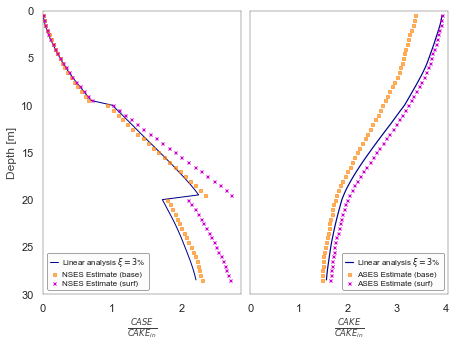

In [10]:
bf, sps = plt.subplots(ncols=2, nrows=1, figsize=(6.5, 5), squeeze=False)
sps = sps.flatten()
sps[0].plot(case_lin / in_cake, odepths, ls="-", label="Linear analysis $\\xi={0:.0f}$%".format(damp * 100), c=cbox(0), lw=1)
sps[1].plot(cake_lin / in_cake, odepths, ls="-", ms=2, label="Linear analysis $\\xi={0:.0f}$%".format(damp * 100), c=cbox(0))
sps[0].plot(pred_case_b / in_cake, odepths, 's', label="NSES Estimate (base)", c=cbox(1), ms=3, alpha=0.6)
sps[1].plot(pred_cake_b / in_cake, odepths, 's', label="ASES Estimate (base)", c=cbox(1), ms=3, alpha=0.6)
sps[0].plot(pred_case_s / in_cake, odepths, "x", ms=3, label="NSES Estimate (surf)", c=cbox(3))
sps[1].plot(pred_cake_s / in_cake, odepths, "x", ms=3, label="ASES Estimate (surf)", c=cbox(3))

# Clean plot
sps[0].set_ylabel("Depth [m]")
sps[0].set_xlabel("$\\frac{CASE}{CAKE_{in}}$")
sps[1].set_xlabel("$\\frac{CAKE}{CAKE_{in}}$")

ef.revamp_legend(sps[0], prop={"size": 8}, loc="lower left")
ef.revamp_legend(sps[-1], prop={"size": 8}, loc="lower right")

for i in range(len(sps)):
    ef.xy(sps[i], x_origin=True, y_origin=True)
    sps[i].set_ylim([0, 30])
    sps[i].invert_yaxis()
    if i != 0:
        sps[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()
bf.subplots_adjust(wspace=0.05, hspace=0)
plt.show()


## Estimate build up of CASE at a specific depth

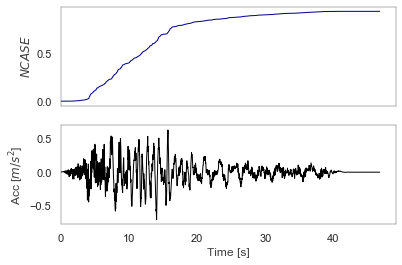

In [13]:
y_depths = np.array([5.])  # compute at 5m
pred_case_b = lq.trigger.nses.est_case_1d_millen_et_al_2019(sp, in_signal, odepths, xi=damp, start=True, trim=True)[0]

bf, sps = plt.subplots(nrows=2, sharex='col')
sps[0].plot(in_signal.time, pred_case_b, c=cbox(0), lw=1)
sps[1].plot(in_signal.time, in_signal.values, c='k', lw=1)
ef.xy(sps[0], x_origin=True)
ef.xy(sps[-1], x_origin=True)
sps[0].set_ylabel('$NCASE$')
sps[1].set_ylabel('Acc [$m/s^2$]')
a = sps[-1].set_xlabel('Time [s]')


References:

 - Millen, M. D. L., Rios, S., Quintero, J., & Viana Da Fonseca, A. (2019). Prediction of time of liquefaction using kinetic and strain energy. Soil Dynamics and Earthquake Engineering, 105898. http://doi.org/10.1016/j.soildyn.2019.105898